In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

# Load the Dataset

In [1]:
from scipy.io import loadmat

# Load the dataset
data = loadmat("EEG driver drowsiness dataset.mat")

# Extract variables
EEG_samples = data['EEGsample']
subject_indexes = data['subindex']
labels = data['substate']

Shape of EEG_samples: (2022, 30, 384)
Shape of subject_indexes: (2022, 1)
Shape of labels: (2022, 1)


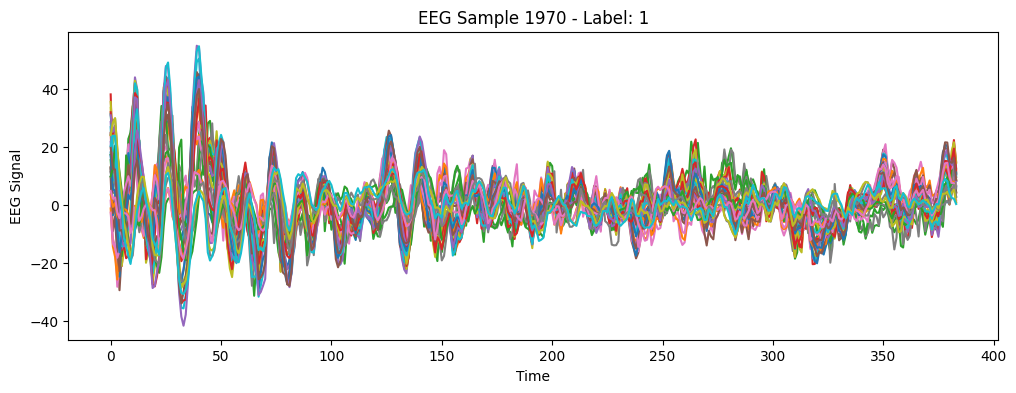

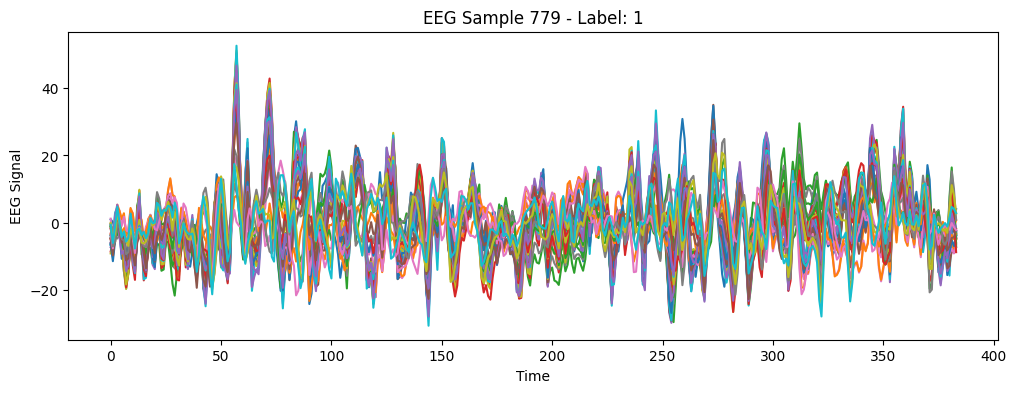

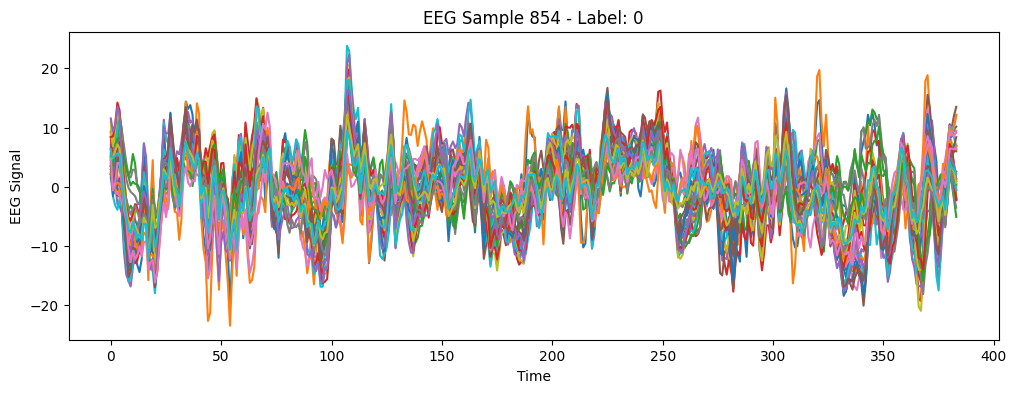

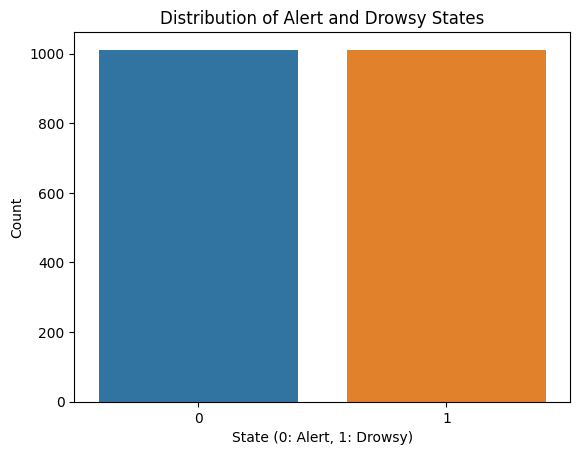

In [6]:
# Check the shape of the arrays
print("Shape of EEG_samples:", EEG_samples.shape)
print("Shape of subject_indexes:", subject_indexes.shape)
print("Shape of labels:", labels.shape)

# Visualize a few EEG samples
num_samples_to_visualize = 3

for i in range(num_samples_to_visualize):
    sample_index = np.random.randint(0, EEG_samples.shape[0])
    eeg_sample = EEG_samples[sample_index, :, :]

    plt.figure(figsize=(12, 4))
    plt.plot(eeg_sample.T)
    plt.title(f"EEG Sample {sample_index + 1} - Label: {labels[sample_index][0]}")
    plt.xlabel("Time")
    plt.ylabel("EEG Signal")
    plt.show()

# Understand the distribution of alert and drowsy states
sns.countplot(x='substate', data=pd.DataFrame(labels, columns=['substate']))
plt.title("Distribution of Alert and Drowsy States")
plt.xlabel("State (0: Alert, 1: Drowsy)")
plt.ylabel("Count")
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the EEG Transformer model
def create_transformer_model(input_shape, num_heads=8, ff_dim=32, num_transformer_blocks=4, mlp_units=[128, 64]):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = inputs

    # Embedding layer
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(x)

    for _ in range(num_transformer_blocks):
        x = create_transformer_block(x, num_heads=num_heads, ff_dim=ff_dim)

    x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


def create_transformer_block(x, num_heads, ff_dim, dropout_rate=0.1):
    attention_dim = int(x.shape[-1]) // num_heads
    x_shape = tf.shape(x)

    # Multi-head self-attention
    x = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=attention_dim, dropout=dropout_rate
    )(x, x)

    # Add and Norm
    x = layers.Add()(x)
    x = layers.LayerNormalization()(x)

    # Feed-forward part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv1D(filters=int(x_shape[-1]), kernel_size=1)(x)

    # Add and Norm
    x = layers.Add()(x)
    x = layers.LayerNormalization()(x)

    return x


# Define input shape based on your EEG data
input_shape = (30, 384)  # Assuming 30 EEG channels and 384 time points

# Create the model
model = create_transformer_model(input_shape=input_shape)

# Display the model architecture
model.summary()


ValueError: A merge layer should be called on a list of inputs. Received: input_shape=(None, 28, 64) (not a list of shapes)